In [1]:
%load_ext autoreload
%autoreload 2

The autoreload module is not an IPython extension.


UsageError: Line magic function `%autoreload` not found.


## Imports

In [2]:
import MDAnalysis as mda
import prolif as plf
import numpy as np
import pandas as pd
from rdkit import DataStructs
import glob
from tqdm import tqdm
import os
import seaborn as sns
import datamol as dm
import rdkit
import matplotlib.pyplot as plt
import torch
import warnings
from rdkit.Chem import AllChem
from copy import deepcopy
import rdkit.Chem as Chem

from src.data.datasets import *
from src.utils.prolif import (
    merge_interaction_dfs,
    generate_interaction_df,
    calculate_interaction_similarity,
)

## Main

In [3]:
def cdf(data, lower=None, upper=None):
    """Calculate the CDF of a dataset."""
    # Number of data points: n
    n = len(data)

    data = np.array(data)
    # clip
    if lower is not None:
        data = data.clip(min=lower)
    if upper is not None:
        data = data.clip(max=upper)

    # x-data for the CDF: x
    x = np.sort(data)

    # y-data for the CDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [4]:
# load datasets
crossdocked_generated = DockedMolsDataset("crossdocked_test", docked=False)
crossdocked_docked = DockedMolsDataset("crossdocked_test", docked=True)

diffsbdd_generated = DiffSBDDSamples(docked=False)
diffsbdd_docked = DiffSBDDSamples(docked=True)

targetdiff_generated = DockedMolsDataset("targetdiff", docked=False)
targetdiff_docked = DockedMolsDataset("targetdiff", docked=True)

p2m_generated = DockedMolsDataset("pocket2mol", docked=False)
p2m_docked = DockedMolsDataset("pocket2mol", docked=True)

sbdd_generated = DockedMolsDataset("ar", docked=False)
sbdd_docked = DockedMolsDataset("ar", docked=True)

cvae_generated = DockedMolsDataset("cvae", docked=False)
cvae_docked = DockedMolsDataset("cvae", docked=True)

In [5]:
targets = [target[:4] for target in crossdocked_generated.names]
assert len(targets) == 100

#### RMSDs for datasets from TargetDiff

In [ ]:
def calculate_rmsds_for_dataset(generated_dataset, docked_dataset, crossdocked=False):
    rmsds = []
    # rmsds_per_sample = []
    targets = [target[:4] for target in generated_dataset.names]

    targets_out = []

    generated_mols = []
    docked_mols = []

    # assert len(generated_dataset.data) == len(docked_dataset.data)

    for i, target in enumerate(tqdm(targets)):
        sample_rmsds = []

        generated_mols_target = generated_dataset.load_mols(idx=i)
        docked_mols_target = docked_dataset.load_mols(idx=i)

        for generated_mol, docked_mol in zip(generated_mols_target, docked_mols_target):
            if generated_mol is not None and docked_mol is not None:
                generated_coords = generated_mol.GetConformer().GetPositions()
                docked_coords = docked_mol.GetConformer().GetPositions()

                try:
                    rmsd = np.sqrt(np.mean((generated_coords - docked_coords) ** 2))
                except:
                    rmsd = np.nan

                rmsds.append(rmsd)
                targets_out.append(target)
                generated_mols.append(generated_mol)
                docked_mols.append(docked_mol)

    df = pd.DataFrame(
        {
            "rmsd": rmsds,
            "target": targets_out,
            "generated": generated_mols,
            "docked": docked_mols,
        }
    )

    return df


crossdocked_df = calculate_rmsds_for_dataset(
    crossdocked_generated, crossdocked_docked, crossdocked=True
)
diffsbdd_df = calculate_rmsds_for_dataset(diffsbdd_generated, diffsbdd_docked)
targetdiff_df = calculate_rmsds_for_dataset(targetdiff_docked, targetdiff_generated)
p2m_df = calculate_rmsds_for_dataset(p2m_generated, p2m_docked)
sbdd_df = calculate_rmsds_for_dataset(sbdd_generated, sbdd_docked)
cvae_df = calculate_rmsds_for_dataset(cvae_generated, cvae_docked)

In [7]:
methods = ["CrossDocked", "DiffSBDD", "TargetDiff", "Pocket2Mol", "3DSBDD", "LiGAN"]
dfs = [crossdocked_df, diffsbdd_df, targetdiff_df, p2m_df, sbdd_df, cvae_df]
for df, method in zip(dfs, methods):
    df["Method"] = method

df = pd.concat([crossdocked_df, diffsbdd_df, targetdiff_df, p2m_df, sbdd_df, cvae_df])
df

,rmsd,target,generated,docked,Method
0,3.165854,2z3h,<rdkit.Chem.rdchem.Mol object at 0x176560540>,<rdkit.Chem.rdchem.Mol object at 0x176d73c30>,CrossDocked
1,1.970519,4aaw,<rdkit.Chem.rdchem.Mol object at 0x10dcbb970>,<rdkit.Chem.rdchem.Mol object at 0x183e4ceb0>,CrossDocked
2,2.552908,4yhj,<rdkit.Chem.rdchem.Mol object at 0x17762c310>,<rdkit.Chem.rdchem.Mol object at 0x183e4ce40>,CrossDocked
3,2.005446,14gs,<rdkit.Chem.rdchem.Mol object at 0x17762c3b0>,<rdkit.Chem.rdchem.Mol object at 0x183e4cf20>,CrossDocked
4,2.038566,2v3r,<rdkit.Chem.rdchem.Mol object at 0x17762c450>,<rdkit.Chem.rdchem.Mol object at 0x183e4cf90>,CrossDocked
...,...,...,...,...,...
8216,1.609571,2pc8,<rdkit.Chem.rdchem.Mol object at 0x181e41cb0>,<rdkit.Chem.rdchem.Mol object at 0x1857ee110>,LiGAN
8217,1.539585,2pc8,<rdkit.Chem.rdchem.Mol object at 0x181e41c10>,<rdkit.Chem.rdchem.Mol object at 0x1857ee180>,LiGAN
8218,1.976807,2pc8,<rdkit.Chem.rdchem.Mol object at 0x181e41ad0>,<rdkit.Chem.rdchem.Mol object at 0x1857ee1f0>,LiGAN
8219,1.816061,2pc8,<rdkit.Chem.rdchem.Mol object at 0x181e41990>,<rdkit.Chem.rdchem.Mol object at 0x1857ee260>,LiGAN


#### Statistics

In [9]:
# summaries by method
df.groupby("Method").agg({"rmsd": ["mean", "median", "std", "min", "max"]})

rmsd                                        
                 mean    median       std       min       max
Method                                                       
3DSBDD       2.577969  2.484208  1.044700  0.050615  7.015024
CrossDocked  3.142580  3.071092  1.235577  0.628160  6.773655
DiffSBDD     2.827867  2.826705  1.541011  0.078650  8.022190
LiGAN        3.292614  3.286080  0.914878  0.076461  6.132389
Pocket2Mol   2.569542  2.536517  0.987185  0.094530  6.498784
TargetDiff   3.130332  3.191357  0.830229  0.075788  6.224361

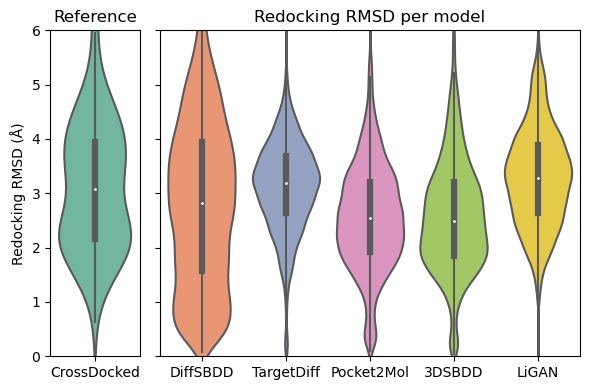

In [23]:
# 2 subplots with ratio 1:2
fig, axes = plt.subplots(
    1,
    2,
    figsize=(6, 4),
    sharey=True,
    gridspec_kw={"width_ratios": [3, 14]},
    tight_layout=True,
)


# violin plot of just crossdocked
sns.violinplot(
    data=df[df["Method"] == "CrossDocked"],
    width=0.8,
    palette="Set2",
    x="Method",
    y="rmsd",
    scale="width",
    ax=axes[0],
)

axes[0].set_ylim(0, 6)
axes[0].set_title("Reference")
axes[0].set_ylabel("Redocking RMSD (Å)")
axes[0].set_xlabel("")

# seaborn Set2 palette but without the 1st color
colors = sns.color_palette("Set2", 6)[1:]

# Violin plot of all methods except crossdocked
sns.violinplot(
    data=df[df["Method"] != "CrossDocked"],
    width=0.8,
    palette=colors,
    x="Method",
    y="rmsd",
    scale="width",
    ax=axes[1],
)

axes[1].set_ylim(0, 6)
axes[1].set_title("Redocking RMSD per model")
axes[1].set_ylabel("")
axes[1].set_xlabel("")

plt.savefig("figures/redocking_rmsd.pdf", bbox_inches="tight")

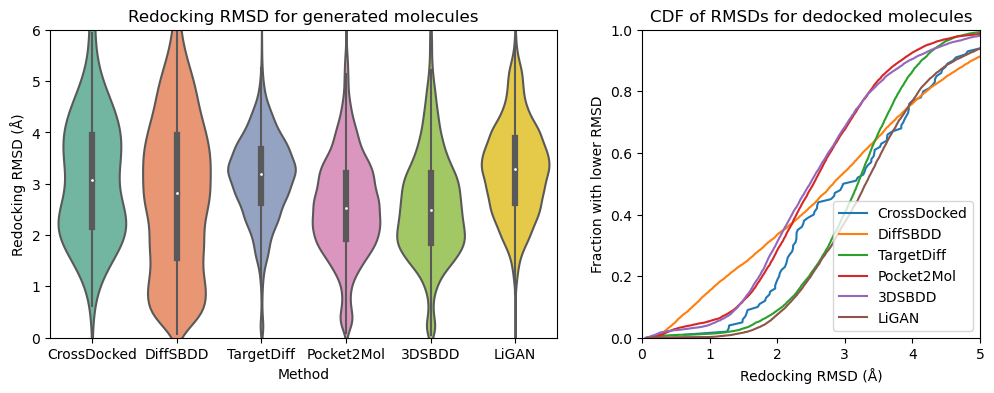

In [10]:
# 2 subplots with ratio 1:2
fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [3, 2]})


# Violin plot
sns.violinplot(
    data=df, width=0.8, palette="Set2", x="Method", y="rmsd", scale="width", ax=axes[0]
)
axes[0].set_ylim(0, 6)
axes[0].set_title("Redocking RMSD for generated molecules")
axes[0].set_ylabel("Redocking RMSD (Å)")

# sns.set_style("white")
sns.set_palette("Set2")

# Density plot
axes[1].plot(*cdf(crossdocked_df["rmsd"]), label="CrossDocked")
axes[1].plot(*cdf(diffsbdd_df["rmsd"]), label="DiffSBDD")
axes[1].plot(*cdf(targetdiff_df["rmsd"]), label="TargetDiff")
axes[1].plot(*cdf(p2m_df["rmsd"]), label="Pocket2Mol")
axes[1].plot(*cdf(sbdd_df["rmsd"]), label="3DSBDD")
axes[1].plot(*cdf(cvae_df["rmsd"]), label="LiGAN")

axes[1].set_xlim(0, 5)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Redocking RMSD (Å)")
axes[1].set_ylabel("Fraction with lower RMSD")
axes[1].set_title("CDF of RMSDs for dedocked molecules")

axes[1].legend(loc="lower right")

plt.savefig("figures/redocking_rmsd.pdf", bbox_inches="tight")

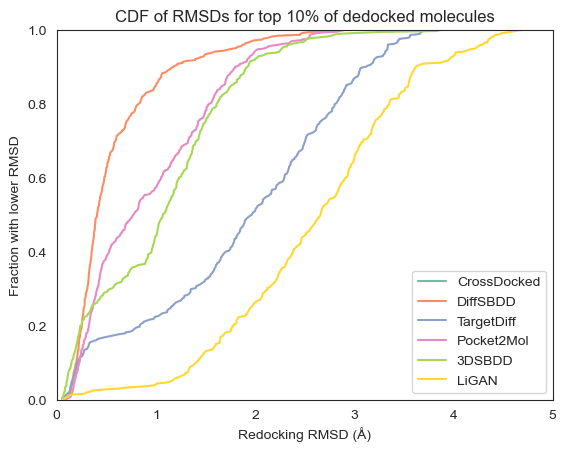

In [56]:
df

# select top 10% of generated molecules by RMSD per target per method
top10 = (
    df.groupby(["Method", "target"])
    .apply(lambda x: x.nsmallest(int(len(x) * 0.05), "rmsd"))
    .reset_index(drop=True)
)

# plot cdf for each method
plt.plot(*cdf(top10[top10["Method"] == "CrossDocked"]["rmsd"]), label="CrossDocked")
plt.plot(*cdf(top10[top10["Method"] == "DiffSBDD"]["rmsd"]), label="DiffSBDD")
plt.plot(*cdf(top10[top10["Method"] == "TargetDiff"]["rmsd"]), label="TargetDiff")
plt.plot(*cdf(top10[top10["Method"] == "Pocket2Mol"]["rmsd"]), label="Pocket2Mol")
plt.plot(*cdf(top10[top10["Method"] == "3DSBDD"]["rmsd"]), label="3DSBDD")
plt.plot(*cdf(top10[top10["Method"] == "LiGAN"]["rmsd"]), label="LiGAN")

plt.xlim(0, 5)
plt.ylim(0, 1)
plt.xlabel("Redocking RMSD (Å)")
plt.ylabel("Fraction with lower RMSD")
plt.title("CDF of RMSDs for top 10% of dedocked molecules")

plt.legend(loc="lower right")

### [Optional] Select 10 targets

In [ ]:
# Select 10 random targets
data = data[
    data["Target"].isin(np.random.choice(data["Target"].unique(), 10, replace=False))
]
data

,RMSD,Target,Method
0,0.745359,14gs,DiffSBDD
1,1.224352,14gs,DiffSBDD
2,4.123366,14gs,DiffSBDD
3,3.414924,14gs,DiffSBDD
4,2.991540,14gs,DiffSBDD
...,...,...,...
38,3.288117,4azf,LiGAN
39,2.845437,4azf,LiGAN
40,3.170121,4azf,LiGAN
41,2.689349,4azf,LiGAN


/var/folders/38/9bdhd5_93c3bfmchy1pn4yj80000gn/T/ipykernel_23629/3970069887.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = df[df['Method'] == 'DiffSBDD'].groupby("target").median().sort_values("rmsd").index


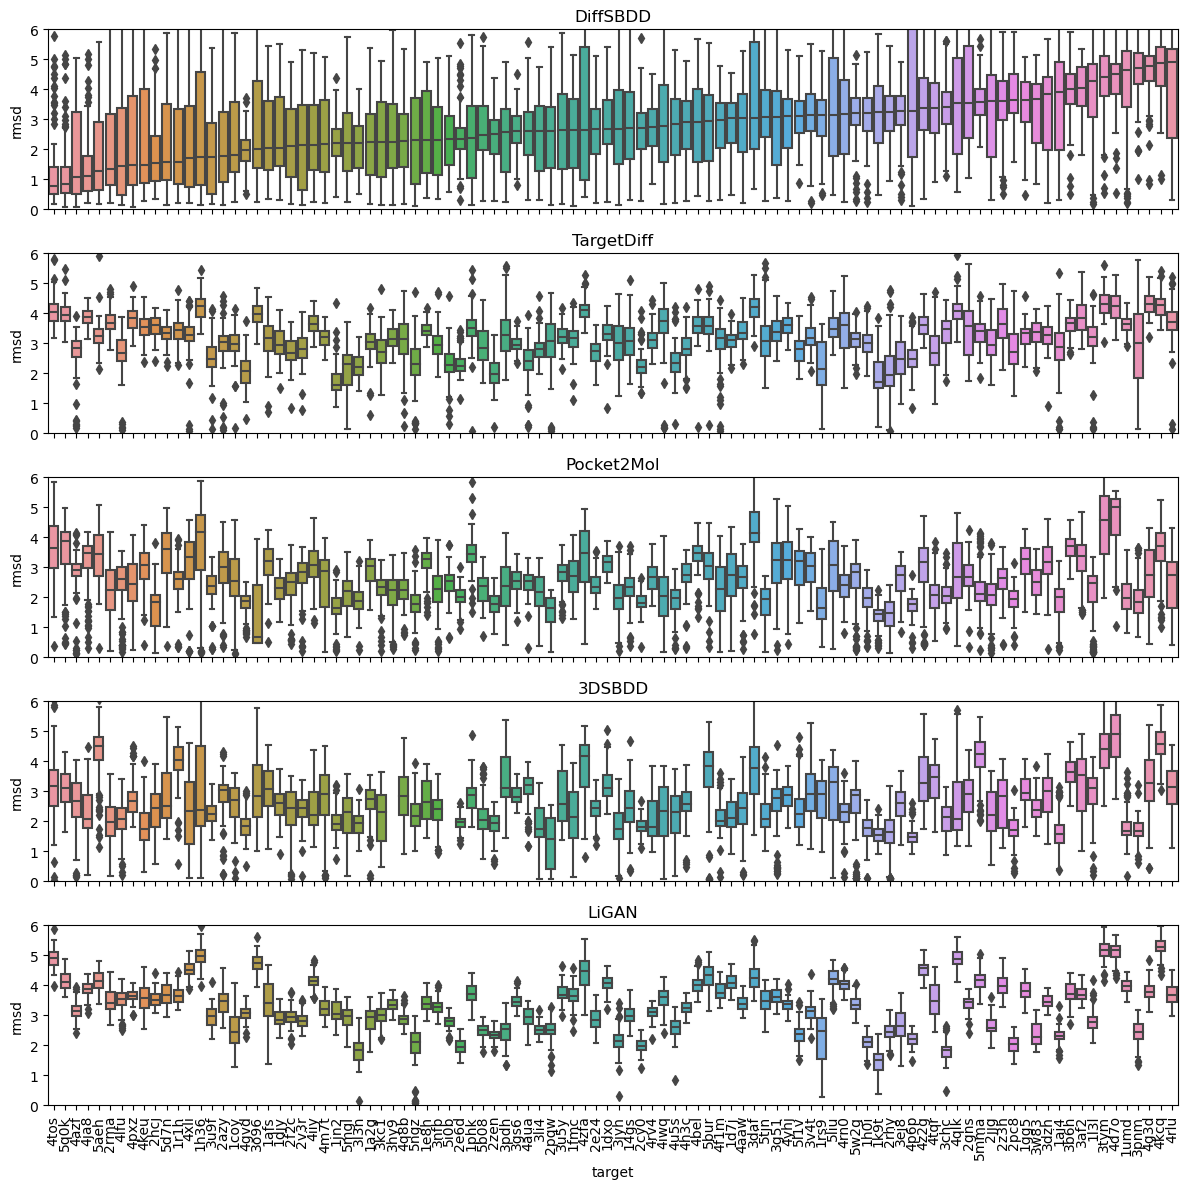

In [33]:
# 4 vertical subplots
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharey=True, sharex=True)
# sort by order of mean RMSD

# get order of targets by median RMSD for targetdiff
order = (
    df[df["Method"] == "DiffSBDD"].groupby("target").median().sort_values("rmsd").index
)
df["target"] = pd.Categorical(df["target"], order)


for i, method in enumerate(["DiffSBDD", "TargetDiff", "Pocket2Mol", "3DSBDD", "LiGAN"]):
    data_method = df[df["Method"] == method]

    # sort by order of mean RMSD
    sns.boxplot(data=data_method, x="target", y="rmsd", ax=axes[i])
    axes[i].set_ylim(0, 6)
    axes[i].set_title(method)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    if i != 4:
        axes[i].set_xlabel("")

plt.tight_layout()

#### Whole RMSDs

#### Combined density and violin plots

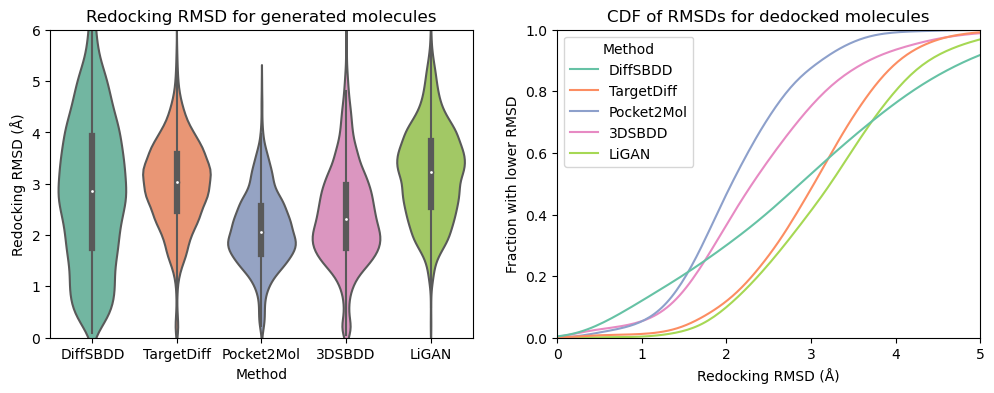

In [415]:
# 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


# Violin plot
sns.violinplot(
    data=data,
    width=0.8,
    palette="Set2",
    x="Method",
    y="RMSD",
    scale="width",
    ax=axes[0],
)
axes[0].set_ylim(0, 6)
axes[0].set_title("Redocking RMSD for generated molecules")
axes[0].set_ylabel("Redocking RMSD (Å)")

# Density plot
sns.kdeplot(
    data=data,
    x="RMSD",
    hue="Method",
    palette="Set2",
    common_norm=False,
    cumulative=True,
    ax=axes[1],
)

axes[1].set_xlim(0, 5)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Redocking RMSD (Å)")
axes[1].set_ylabel("Fraction with lower RMSD")
axes[1].set_title("CDF of RMSDs for dedocked molecules")

plt.savefig("figures/redocking_rmsd.pdf", bbox_inches="tight")

In [414]:
for method, rmsds in zip(
    ["DiffSBDD", "TargetDiff", "Pocket2Mol", "3DSBDD", "LiGAN"], mean_rmsds
):
    table_string = (
        f"{method} & " + " & ".join([f"{rmsd:.2f}" for rmsd in rmsds]) + " \\\\"
    )
    print(table_string)

DiffSBDD & 0.56 & 0.87 & 1.68 & 2.89 \\
TargetDiff & 1.47 & 1.81 & 2.34 & 3.00 \\
Pocket2Mol & 0.90 & 1.16 & 1.54 & 2.12 \\
3DSBDD & 0.84 & 1.17 & 1.65 & 2.40 \\
LiGAN & 1.69 & 1.94 & 2.47 & 3.21 \\


### DiffSBDD